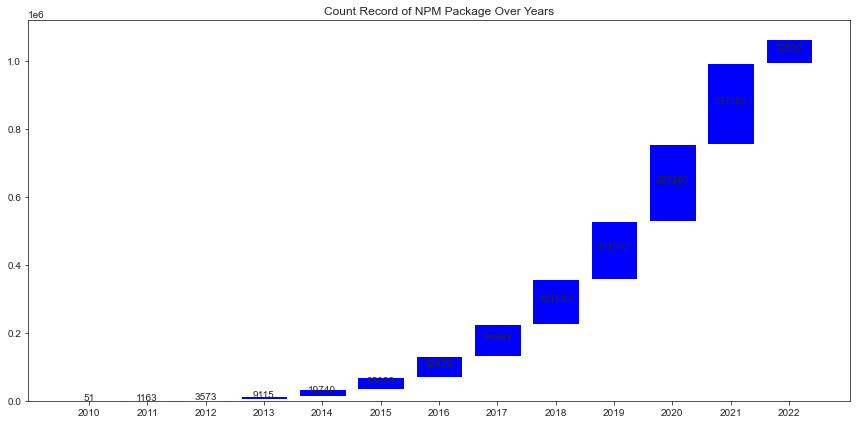

In [40]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database='supply_chain'
)

sql_query = """
SELECT
    toYear(time) AS year,
    count() AS record_count
FROM
    npm_records_v2
GROUP BY
    year
ORDER BY
    year;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["year", "record_count"])

# Convert the year column to string for plotting
df["year"] = df["year"].astype(str)

# 计算变化量和累计量
df["change"] = df["record_count"]
df["cumulative"] = df["record_count"].cumsum()

# 设置图形的基础信息
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["blue" for _ in df["change"]]
bars = ax.bar(df["year"], df["change"], bottom=df["cumulative"] - df["change"], color=colors)
ax.axhline(0, color="k", linewidth=0.5)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height/2),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='center')

plt.title("Count Record of NPM Package Over Years")
plt.tight_layout()
plt.show()


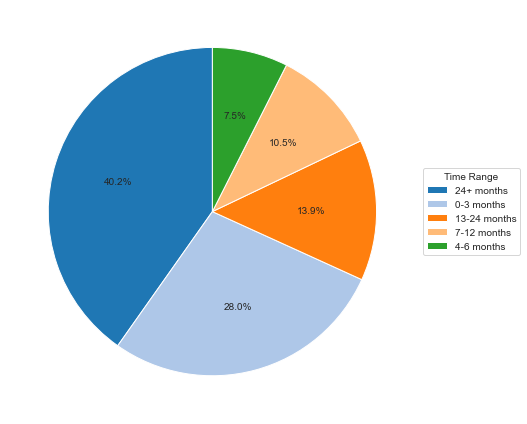

In [30]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database='supply_chain'
)

# SQL query
sql_query = """
SELECT COUNT(*) AS count, time_range
FROM outdated_dependencies_v2
GROUP BY time_range;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["count", "time_range"])

# Sort dataframe for better color consistency
df.sort_values('count', ascending=False, inplace=True)

# Plotting pie chart
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors
colors = plt.get_cmap('tab20')(range(len(df)))

# Create pie chart
wedges, texts, autotexts = ax.pie(
    df["count"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Add legend outside the plot
plt.legend(
    wedges, df["time_range"],
    title="Time Range",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Set a more academic title
# plt.title("Figure 1: Distribution of Outdated Dependencies by Time Range", pad=20)

# Use tight layout to fit into an academic paper format
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig("outdated_dependencies_distribution.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


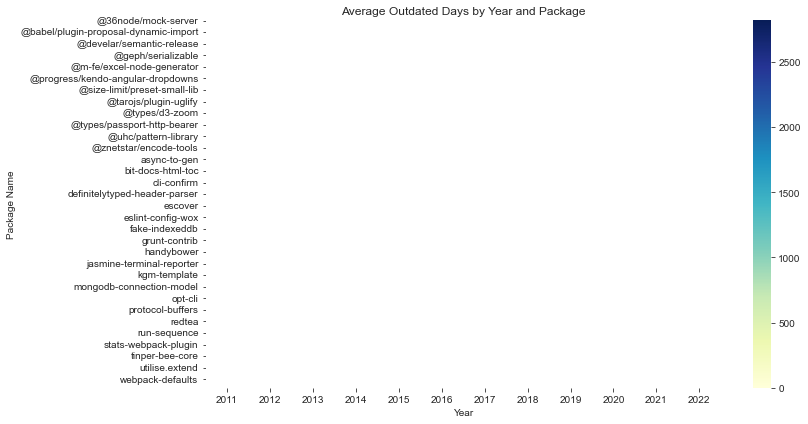

In [50]:
from clickhouse_driver import Client
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database='supply_chain'
)

# SQL query
sql_query = """
SELECT
    toStartOfMonth(time) as month,
    name,
    AVG(days_difference) as avg_outdated_days
FROM npm_analysis_result_v2
GROUP BY month, name;
"""

# Fetch data
data = ch_client.execute(sql_query)
df = pd.DataFrame(data, columns=['month', 'name', 'avg_outdated_days'])

# Convert the 'month' column to datetime and extract the year
df['year'] = pd.to_datetime(df['month']).dt.year

# Group by year and name, then compute average outdated days
df_grouped = df.groupby(['year', 'name']).avg_outdated_days.mean().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 6))
heatmap_data = df_grouped.pivot_table(values="avg_outdated_days", index="name", columns="year").fillna(0)
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, vmin=0, vmax=heatmap_data.values.max())

plt.title("Average Outdated Days by Year and Package")
plt.ylabel("Package Name")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


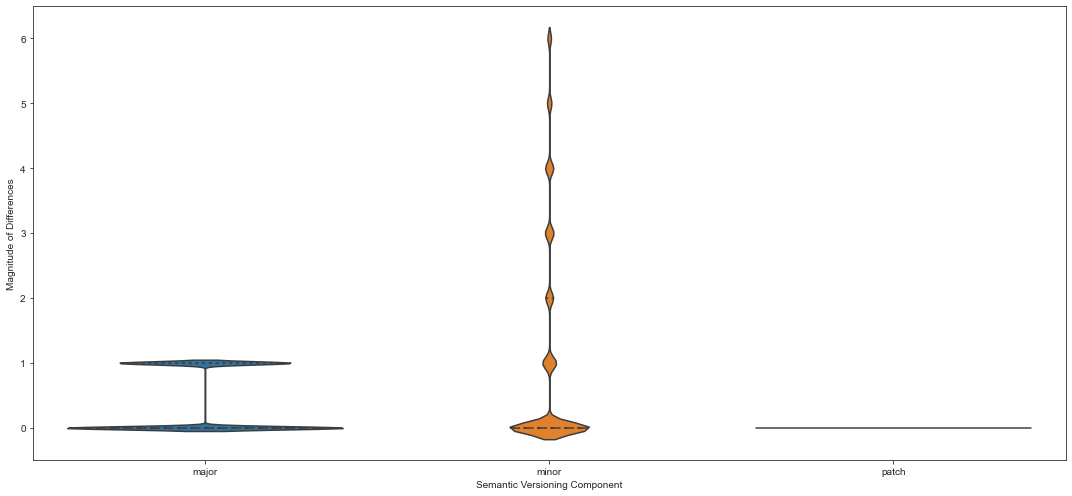

In [53]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)

sql_query = """
SELECT
    major_difference AS major,
    minor_difference AS minor,
    patch_difference AS patch,
    SUM(occurrences) AS total_occurrences
FROM version_difference_filtered_v2
WHERE
    (major_difference < 0) OR
    (minor_difference < 0) OR
    (patch_difference < 0)
GROUP BY major, minor, patch
ORDER BY total_occurrences DESC;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["major", "minor", "patch", "total_occurrences"])

# Convert all negative values to positive
for col in ["major", "minor", "patch"]:
    df[col] = df[col].abs()

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars=["total_occurrences"], value_vars=["major", "minor", "patch"],
                    var_name="Version Component", value_name="Difference Magnitude")

# Repeat each row based on the 'total_occurrences' column
df_melted = df_melted.loc[df_melted.index.repeat(df_melted['total_occurrences'])].reset_index(drop=True)

#  Remove outliers based on IQR for each "Version Component"
multiplier = 0.25  # 调整为1.25
components = ["major", "minor", "patch"]
for component in components:
    component_data = df_melted[df_melted["Version Component"] == component]["Difference Magnitude"]
    Q1 = component_data.quantile(0.25)
    Q3 = component_data.quantile(0.75)
    IQR = Q3 - Q1
    filter_mask = ((component_data >= (Q1 - multiplier * IQR)) & (component_data <= (Q3 + multiplier * IQR)))
    df_melted = df_melted[(df_melted["Version Component"] != component) | filter_mask]


# Plotting the data using seaborn without outliers
plt.figure(figsize=(15, 7))
sns.violinplot(x="Version Component", y="Difference Magnitude", data=df_melted, inner="quartile")
plt.ylabel("Magnitude of Differences")
plt.xlabel("Semantic Versioning Component")

plt.tight_layout()
plt.show()


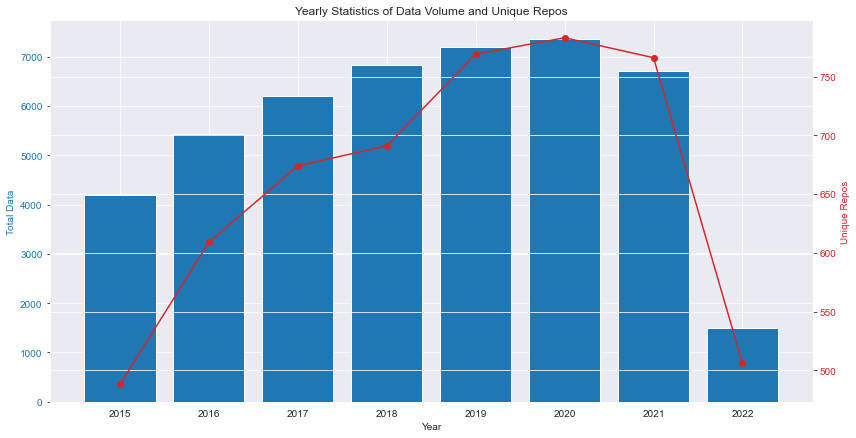

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('data/merged.csv')

# 提取年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 按年份统计数据量和repo_name的唯一数量
grouped_data = df.groupby('Year').agg(
    total_data=pd.NamedAgg(column='Date', aggfunc='count'),
    unique_repos=pd.NamedAgg(column='repo_name', aggfunc='nunique')
).reset_index()

# 绘制数据总量和repo_name的总量的条形图
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Data', color=color)
ax1.bar(grouped_data['Year'], grouped_data['total_data'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Unique Repos', color=color)
ax2.plot(grouped_data['Year'], grouped_data['unique_repos'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly Statistics of Data Volume and Unique Repos')
plt.show()


In [5]:
import pandas as pd

# 读取数据
df = pd.read_csv('data/merged.csv')

# 提取年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 按年份统计数据量和repo_name的唯一数量
grouped_data = df.groupby('Year').agg(
    total_data=pd.NamedAgg(column='Date', aggfunc='count'),
    unique_repos=pd.NamedAgg(column='repo_name', aggfunc='nunique')
).reset_index()

print(grouped_data)


   Year  total_data  unique_repos
0  2015        4192           488
1  2016        5432           609
2  2017        6200           674
3  2018        6821           691
4  2019        7204           769
5  2020        7366           783
6  2021        6707           766
7  2022        1499           506


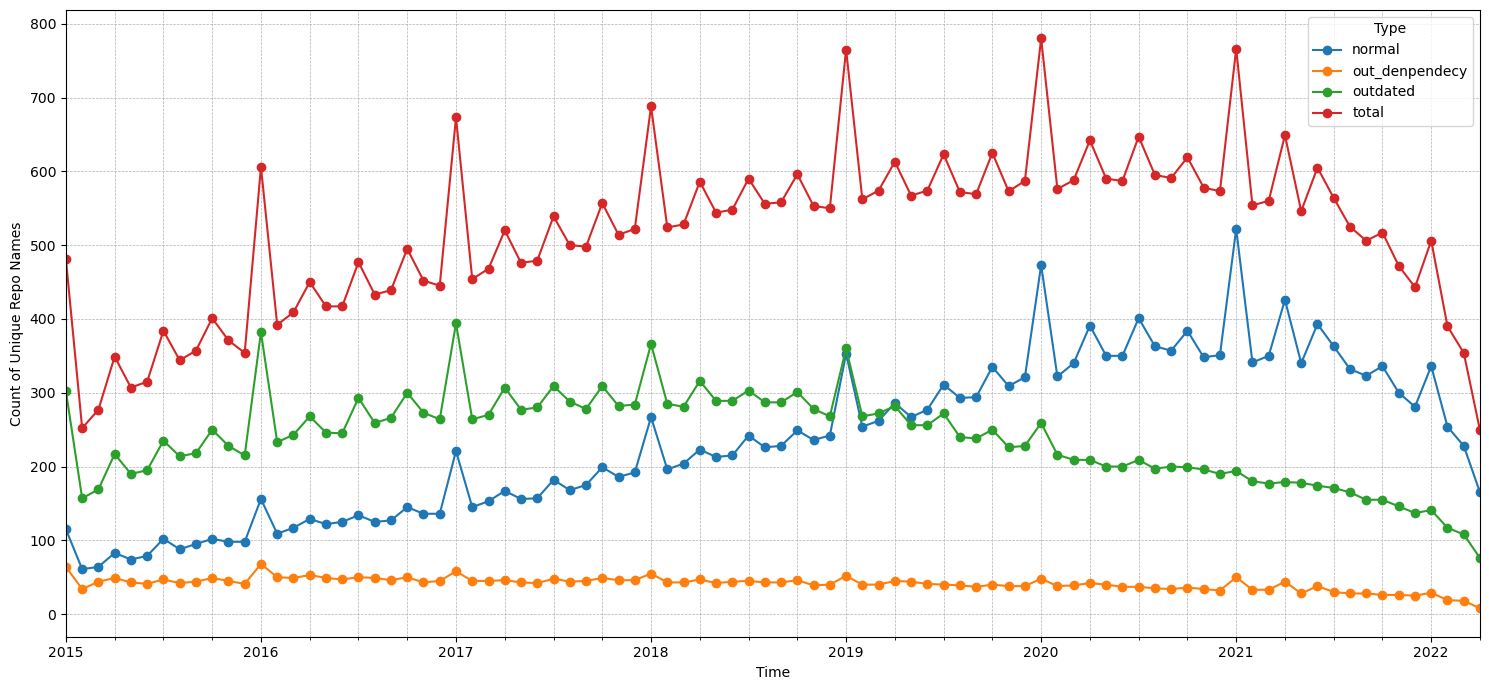

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV file
df = pd.read_csv('data/merged_with_type.csv')

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group by YearMonth and type, and count unique repo_names
repo_name_counts_by_type = df.groupby(['YearMonth', 'type'])['repo_name'].nunique().unstack()

# Add a total count for all repo_name types
repo_name_counts_by_type['total'] = repo_name_counts_by_type.sum(axis=1)

# Create a new figure and set the size
plt.figure(figsize=(15, 7))

# Plot the count of unique repo_names for each type
for column in repo_name_counts_by_type.columns:
    repo_name_counts_by_type[column].plot(label=column, marker='o', linestyle='-')

# Set the title, labels, and legend
# plt.title('Unique Repo Names by Year, Month, and Type')  # Un-comment this line if you want a title
plt.xlabel('Time')
plt.ylabel('Count of Unique Repo Names')
plt.legend(title='Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure the background is white
plt.style.use('default')
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Display the plot
plt.tight_layout()
plt.show()


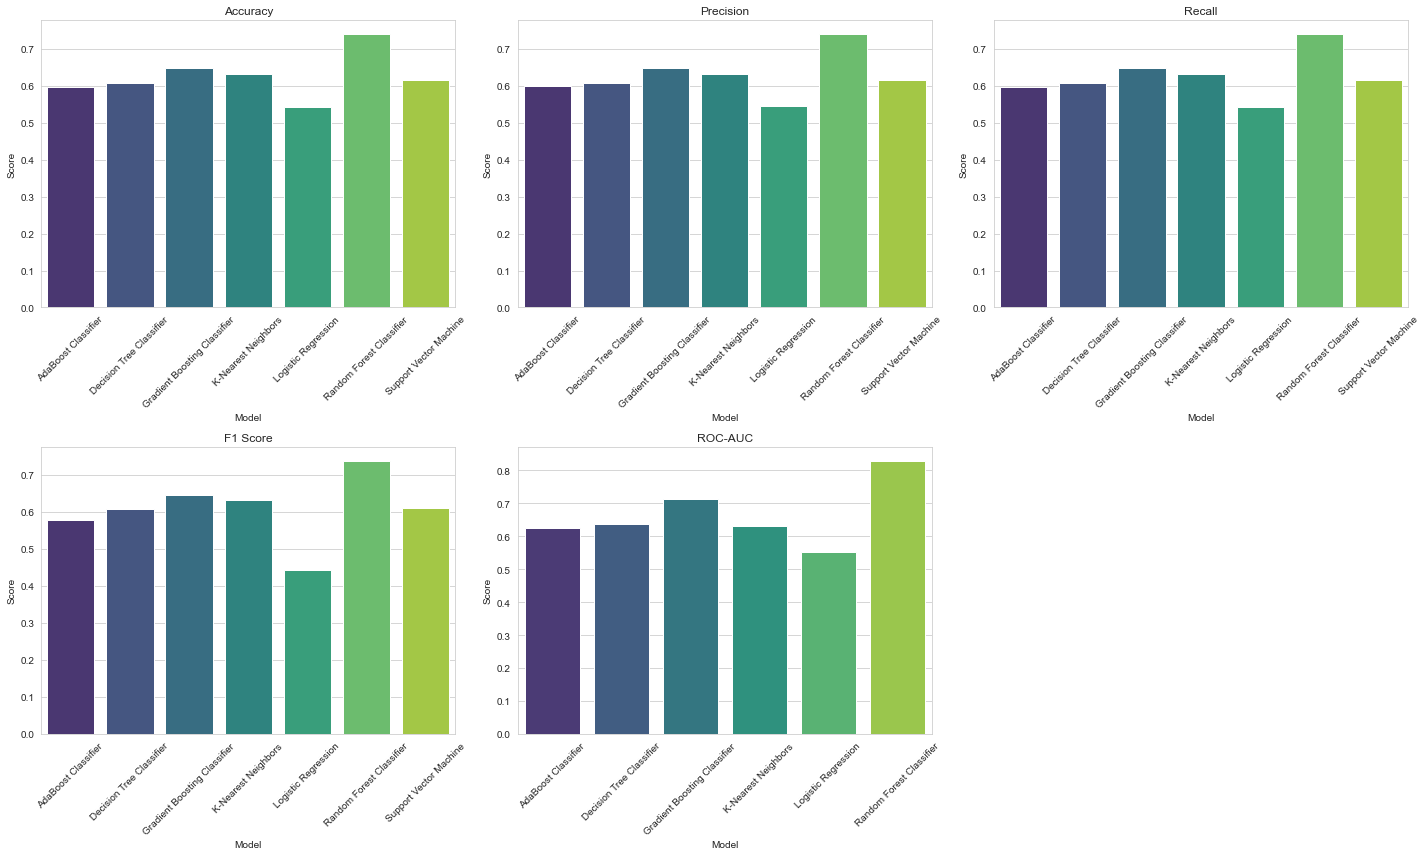

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Loading metrics
models = [
    "AdaBoost Classifier", "Decision Tree Classifier", "Gradient Boosting Classifier",
    "K-Nearest Neighbors", "Logistic Regression", "Random Forest Classifier",
    "Support Vector Machine"
]
metrics_data = {}

for model in models:
    df = pd.read_csv(f"./result/{model}_metrics.csv")
    # Replace 'Not Available' with NaN and drop such rows
    df = df.replace('Not Available', float('nan')).dropna(subset=['Value'])
    df["Value"] = df["Value"].astype(float)  # Ensure the values are float
    metrics_data[model] = df

# Setting Seaborn style
sns.set_style("whitegrid")

# Plotting metrics in one plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

data = []
for model in models:
    for metric in metrics:
        if metric in metrics_data[model]['Metric'].values:
            value = metrics_data[model].set_index("Metric").loc[metric, "Value"]
            data.append([model, metric, value])

df_plot = pd.DataFrame(data, columns=["Model", "Metric", "Value"])

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    sns.barplot(data=df_plot[df_plot["Metric"] == metric], x="Model", y="Value", ax=ax, palette="viridis")
    ax.set_title(metric)
    ax.set_ylabel("Score")
    ax.set_xlabel("Model")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove the unused subplot (bottom right corner)
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


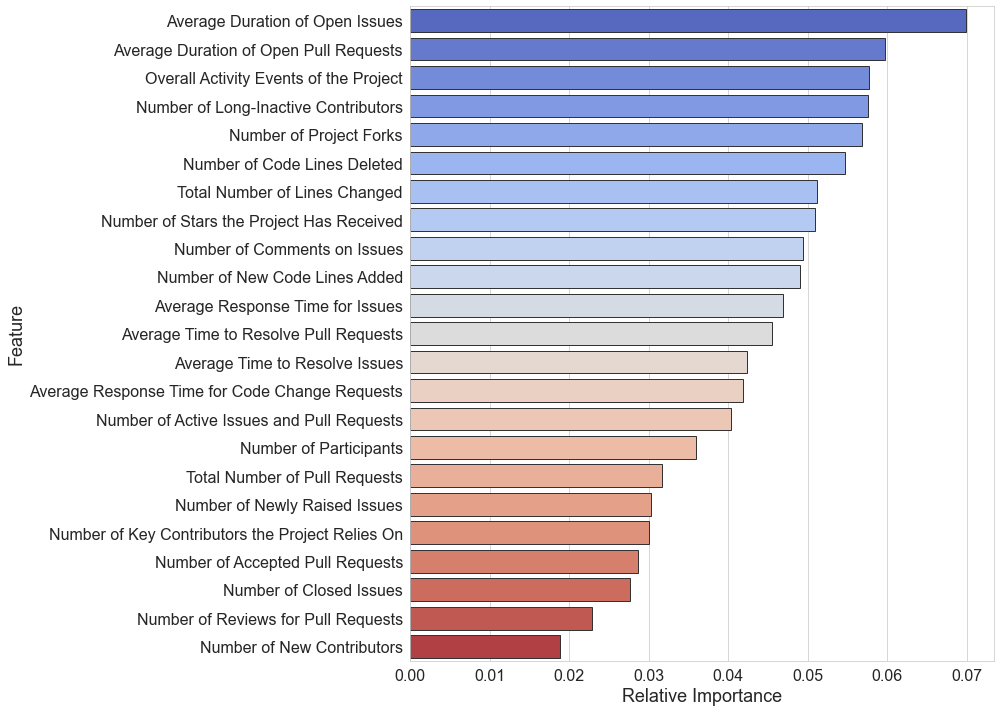

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Updated map for original feature to descriptive names
feature_mapping = {
    "new_contributors": "Number of New Contributors",
    "change_request_response_time_avg": "Average Response Time for Code Change Requests",
    "issue_age_avg": "Average Duration of Open Issues",
    "code_change_lines_sum": "Total Number of Lines Changed",
    "issues_new": "Number of Newly Raised Issues",
    "issues_and_change_request_active": "Number of Active Issues and Pull Requests",
    "code_change_lines_add": "Number of New Code Lines Added",
    "attention": "Number of Project Forks",
    "issue_comments": "Number of Comments on Issues",
    "change_requests_accepted": "Number of Accepted Pull Requests",
    "change_request_age_avg": "Average Duration of Open Pull Requests",
    "participants": "Number of Participants",
    "bus_factor": "Number of Key Contributors the Project Relies On",
    "code_change_lines_remove": "Number of Code Lines Deleted",
    "inactive_contributors": "Number of Long-Inactive Contributors",
    "change_requests_reviews": "Number of Reviews for Pull Requests",
    "activity": "Overall Activity Events of the Project",
    "change_request_resolution_duration_avg": "Average Time to Resolve Pull Requests",
    "issues_closed": "Number of Closed Issues",
    "change_requests": "Total Number of Pull Requests",
    "issue_response_time_avg": "Average Response Time for Issues",
    "issue_resolution_duration_avg": "Average Time to Resolve Issues",
    "stars": "Number of Stars the Project Has Received"
}

# Read the data
df = pd.read_csv("./result/Random Forest Classifier_feature_importances.csv")

# Map the features to their descriptive names
df['Feature'] = df['Feature'].map(feature_mapping)

# Sort by Importance for better visualization
df = df.sort_values(by="Importance", ascending=False)

# Set style for the plot
sns.set_style("whitegrid")

# Set a larger figure size for better readability
plt.figure(figsize=(14, 10))

# Create a color palette
palette = sns.color_palette("coolwarm", len(df))

# Plot - flipped x and y for a horizontal bar plot
sns.barplot(y="Feature", x="Importance", data=df, palette=palette, edgecolor=".2")

# Title and labels
# plt.title("Feature Importances as Determined by Random Forest Classifier", fontsize=20, pad=20)
plt.xlabel("Relative Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [5]:
import pandas as pd

# Model list
models = [
    "AdaBoost Classifier", "Decision Tree Classifier", "Gradient Boosting Classifier",
    "K-Nearest Neighbors", "Logistic Regression", "Random Forest Classifier",
    "Support Vector Machine"
]

# Placeholder for the data
all_metrics = []

# Loop through each model to read the metrics file and append to all_metrics
for model in models:
    df = pd.read_csv(f"./result/{model}_metrics.csv")
    df['Model'] = model
    all_metrics.append(df)

# Concatenate all metrics data
consolidated_metrics = pd.concat(all_metrics, ignore_index=True)

# Save the consolidated data to a new file
consolidated_metrics.to_csv("./result/Consolidated_Metrics.csv", index=False)


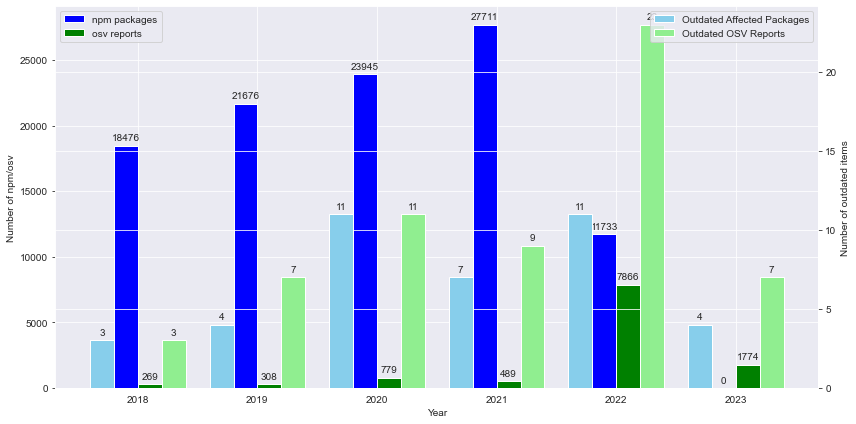

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 数据准备
data = {
    'Year': ['2018', '2019', '2020', '2021', '2022', '2023'],
    'npm_packages': [18476, 21676, 23945, 27711, 11733, 0],
    'osv_reports': [269, 308, 779, 489, 7866, 1774],
    'outdated_affected_packages': [3, 4, 11, 7, 11, 4],
    'outdated_osv_reports': [3, 7, 11, 9, 23, 7]
}

df = pd.DataFrame(data)
x = np.arange(len(df['Year']))  # the label locations

# 条形图宽度
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# 主要柱状图
rects1 = ax1.bar(x - width/2, df['npm_packages'], width, label='npm packages', color='blue')
rects2 = ax1.bar(x + width/2, df['osv_reports'], width, label='osv reports', color='green')

# 第二个轴（共享x轴）
ax2 = ax1.twinx()

# 次要柱状图
rects3 = ax2.bar(x - 3*width/2, df['outdated_affected_packages'], width, label='Outdated Affected Packages', color='skyblue')
rects4 = ax2.bar(x + 3*width/2, df['outdated_osv_reports'], width, label='Outdated OSV Reports', color='lightgreen')

# 添加文本标签
def autolabel(rects, ax, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2, 'left')
autolabel(rects4, ax2, 'right')

# 设置图表标题和坐标轴标签
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of npm/osv')
ax2.set_ylabel('Number of outdated items')

# 设置x轴刻度标签
ax1.set_xticks(x)
ax1.set_xticklabels(df['Year'])

# 图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

plt.show()


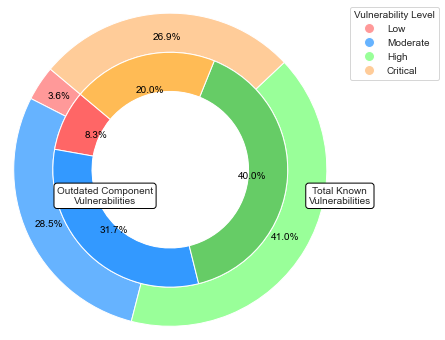

In [29]:
import matplotlib.pyplot as plt

categories = ['Low', 'Moderate', 'High', 'Critical']
outer_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
inner_colors = ['#ff6666','#3399ff','#66cc66','#ffbb55']
package_vulns_pct = [8.33, 31.67, 40.00, 20.00]
total_vulns_pct = [3.60, 28.51, 41.03, 26.87]

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

wedges1, texts1, autotexts1 = ax.pie(total_vulns_pct, radius=1.2, colors=outer_colors, startangle=140,
                                     wedgeprops=dict(width=0.3, edgecolor='w'),
                                     autopct='%1.1f%%', pctdistance=0.85)

wedges2, texts2, autotexts2 = ax.pie(package_vulns_pct, radius=0.9, colors=inner_colors, startangle=140,
                                     wedgeprops=dict(width=0.3, edgecolor='w'),
                                     autopct='%1.1f%%', pctdistance=0.7)

centre_circle = plt.Circle((0,0),0.6, color='white', fc='white', linewidth=0)
fig.gca().add_artist(centre_circle)

# plt.title('Vulnerability Analysis by Source', pad=20)

for autotext in autotexts1 + autotexts2:
    autotext.set_color('black')

def add_pie_annotation(text, xpos, ypos):
    ax.text(xpos, ypos, text, ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

add_pie_annotation('Outdated Component\nVulnerabilities', -0.5, -0.2)
add_pie_annotation('Total Known\nVulnerabilities', 1.3, -0.2)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                              markerfacecolor=oc, markersize=10) for cat, oc in zip(categories, outer_colors)]
ax.legend(handles=legend_elements, title="Vulnerability Level", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()
